In [1]:
# Import bibliotek
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Pobranie danych
import kagglehub

path = kagglehub.dataset_download("taweilo/loan-approval-classification-data")

print("Path to dataset files:", path)

df = pd.read_csv(path + "/loan_data.csv")
print(df.head())  # Podgląd pierwszych 5 wierszy

Path to dataset files: /root/.cache/kagglehub/datasets/taweilo/loan-approval-classification-data/versions/1
   person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb

In [3]:
print(df.columns)

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')


In [4]:
df.drop(columns=["person_gender","person_emp_exp","loan_intent"], inplace=True, errors="ignore")

In [5]:
df["previous_loan_defaults_on_file"] = df["previous_loan_defaults_on_file"].astype(str).str.strip()

# Mapowanie
df["previous_loan_defaults_on_file"] = df["previous_loan_defaults_on_file"].map({"No": 0, "Yes": 1})
# Uzupełnienie brakujących wartości NaN zerami i konwersja na int
df["previous_loan_defaults_on_file"] = df["previous_loan_defaults_on_file"].fillna(0).astype(int)

# Sprawdzenie czy konwersja się udała
print(df["previous_loan_defaults_on_file"].unique())  # Powinno pokazać tylko [0, 1]
print(df["previous_loan_defaults_on_file"].dtype)  # Powinno być int64

[0 1]
int64


In [6]:
print(df["previous_loan_defaults_on_file"].unique())

[0 1]


In [7]:
df["person_home_ownership"] = df["person_home_ownership"].map({
    "RENT": 0,        # Najmniejsza stabilność finansowa
    "MORTGAGE": 1,    # Kredyt hipoteczny, ale zadłużenie
    "OWN": 2,         # Największa stabilność finansowa
    "Other": 1        # Traktujemy podobnie jak mortgage
})

In [8]:
df["person_education"] = df["person_education"].map({
    "High School": 0,      # Najniższe wykształcenie i niższe zarobki
    "Associate": 1,        # Średni poziom wykształcenia
    "Bachelor": 2,         # Wyższe wykształcenie i większa szansa na zarobki
    "Other": 1             # Traktujemy jak "Associate" bo nie wiemy dokładnie
})

In [9]:
cechy_wazne = ["person_income", "loan_amnt", "loan_int_rate",
               "cb_person_cred_hist_length", "credit_score",
               "previous_loan_defaults_on_file", "person_age",
               "person_home_ownership" ,"loan_percent_income",
               "person_education"]

#Cechy i etykiety
X = df[cechy_wazne]
Y = df["loan_status"]
# Sprawdzenie 5 pierwszych kolumn
print(df.head())


   person_age  person_education  person_income  person_home_ownership  \
0        22.0               NaN        71948.0                    0.0   
1        21.0               0.0        12282.0                    2.0   
2        25.0               0.0        12438.0                    1.0   
3        23.0               2.0        79753.0                    0.0   
4        24.0               NaN        66135.0                    0.0   

   loan_amnt  loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0    35000.0          16.02                 0.49                         3.0   
1     1000.0          11.14                 0.08                         2.0   
2     5500.0          12.87                 0.44                         3.0   
3    35000.0          15.23                 0.44                         2.0   
4    35000.0          14.27                 0.53                         4.0   

   credit_score  previous_loan_defaults_on_file  loan_status  
0           561  

In [10]:
print(df[cechy_wazne].dtypes)

person_income                     float64
loan_amnt                         float64
loan_int_rate                     float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file      int64
person_age                        float64
person_home_ownership             float64
loan_percent_income               float64
person_education                  float64
dtype: object


In [11]:
#Sprawdzanie jakich danych brakuje
print(df.isnull().sum())

person_age                           0
person_education                  7601
person_income                        0
person_home_ownership              117
loan_amnt                            0
loan_int_rate                        0
loan_percent_income                  0
cb_person_cred_hist_length           0
credit_score                         0
previous_loan_defaults_on_file       0
loan_status                          0
dtype: int64


In [16]:
print(df["previous_loan_defaults_on_file"].dtype)

int64


In [15]:
print(df[["person_home_ownership", "previous_loan_defaults_on_file", "person_education"]].isnull().sum())

person_home_ownership              117
previous_loan_defaults_on_file       0
person_education                  7601
dtype: int64


In [19]:
print(df.isnull().sum())
# Uzupełnianie NaN najczęściej występującą wartością
df.loc[:, "person_home_ownership"] = df["person_home_ownership"].fillna(df["person_home_ownership"].mode()[0])
df.loc[:, "person_education"] = df["person_education"].fillna(df["person_education"].mode()[0])

# Konwersja na liczby całkowite
df["person_home_ownership"] = df["person_home_ownership"].astype(int)
df["person_education"] = df["person_education"].astype(int)

# Ostateczne sprawdzenie
print(df.dtypes)  # Wszystkie powinny być int lub float
print(df.isnull().sum())  # Powinno pokazać 0 dla każdej kolumny

person_age                           0
person_education                  7601
person_income                        0
person_home_ownership              117
loan_amnt                            0
loan_int_rate                        0
loan_percent_income                  0
cb_person_cred_hist_length           0
credit_score                         0
previous_loan_defaults_on_file       0
loan_status                          0
dtype: int64
person_age                        float64
person_education                    int64
person_income                     float64
person_home_ownership               int64
loan_amnt                         float64
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file      int64
loan_status                         int64
dtype: object
person_age                        0
person_education                  0
person_inc

In [20]:
print(df["person_home_ownership"].unique())
print(df["person_education"].unique())

[0 2 1]
[2 0 1]


In [21]:
print(df.dtypes)

person_age                        float64
person_education                    int64
person_income                     float64
person_home_ownership               int64
loan_amnt                         float64
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file      int64
loan_status                         int64
dtype: object


In [22]:
# Podział na zestaw treningowy i testowy (80% trening, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

In [23]:
# Sprawdzanie czy zbiory są zbalansowane
print(len(Y_train))
print(len(X_train))
print(len(Y_test))
print(len(X_test))

36000
36000
9000
9000


In [24]:
# Definiowanie siatki parametrów do przetestowania
param_grid = {
    'max_depth': [6, 8, 10, 12],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 10]
}

# GridSearchCV do znalezienia najlepszych parametrów
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=5), param_grid, cv=5)
grid_search.fit(X_train, Y_train)  # Uwaga: 'Y_train' powinno być 'y_train' zgodnie z wcześniejszym kodem

# Pobieranie najlepszego zestawu hiperparametrów
print("Najlepsze parametry:", grid_search.best_params_)

# Tworzenie i trenowanie na podstawie najlepszych parametrów
best_params = grid_search.best_params_
model = DecisionTreeClassifier(
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=5
)

# Ponowne trenowanie modelu
model.fit(X_train, Y_train)

# Dokładność modelu
y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Dokładność modelu po tuningu: {accuracy:.4f}")

Najlepsze parametry: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 15}
Dokładność modelu po tuningu: 0.9142


In [25]:
#Sprawdzamy czy nie ma przeuczenia:
# Predykcja na zbiorze treningowym
y_train_pred = model.predict(X_train)
train_acc = accuracy_score(Y_train, y_train_pred)

# Predykcja na zbiorze testowym
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(Y_test, y_test_pred)

print(f" Dokładność na zbiorze treningowym: {train_acc:.4f}")
print(f" Dokładność na zbiorze testowym: {test_acc:.4f}")

 Dokładność na zbiorze treningowym: 0.9262
 Dokładność na zbiorze testowym: 0.9142


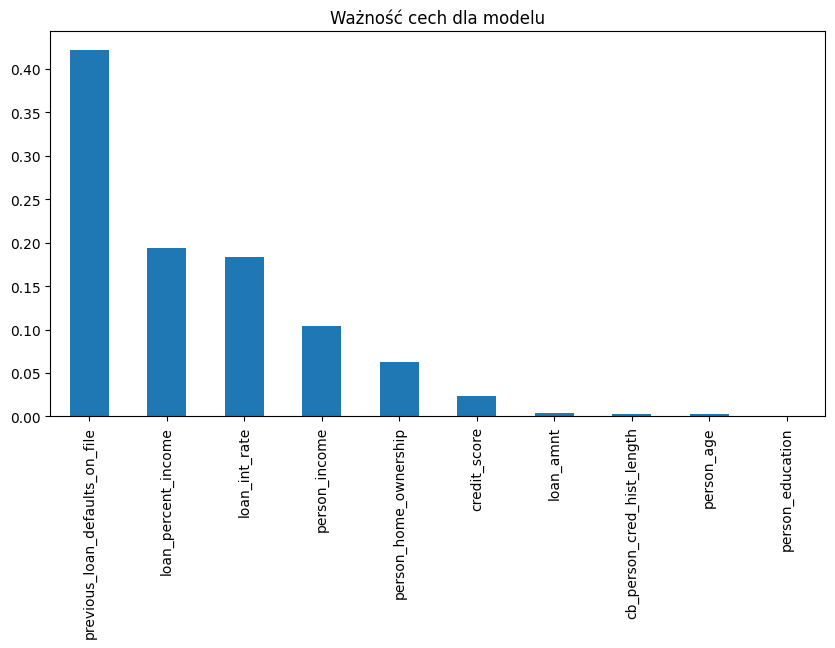

In [26]:
# Ważność cech
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Ważność cech dla modelu")
plt.show()

In [27]:
# Ważność cech w procentach
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False) * 100  # Zamiana na procenty

# Wyświetlanie
print("Ważność cech dla modelu (%):")
print(feature_importance.to_string(float_format="%.2f"))

Ważność cech dla modelu (%):
previous_loan_defaults_on_file   42.20
loan_percent_income              19.37
loan_int_rate                    18.36
person_income                    10.40
person_home_ownership             6.23
credit_score                      2.37
loan_amnt                         0.41
cb_person_cred_hist_length        0.32
person_age                        0.30
person_education                  0.04
